# 10.02 - Resampling y Ventanas Deslizantes

**Autor:** Miguel Angel Vazquez Varela  
**Nivel:** Intermedio  
**Tiempo estimado:** 40 min

---

## ¿Qué aprenderás?

- `resample()`: cambiar la granularidad temporal de una serie (downsampling / upsampling)
- `rolling()`: calcular estadísticas sobre ventanas deslizantes
- `ewm()`: medias móviles exponenciales para suavizado adaptativo
- Comparar visualmente la señal original vs. suavizada

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
# Dataset: demanda horaria de bicicletas durante 90 dias
np.random.seed(42)

idx = pd.date_range(start='2024-01-01', end='2024-03-31', freq='h')

# Simulamos patron realista: mas demanda de dia, picos en horas punta
hour_pattern = np.sin(np.pi * idx.hour.values / 12) * 20 + 20  # ciclo diario
weekday_factor = np.where(idx.dayofweek < 5, 1.3, 0.8)  # mas entre semana
noise = np.random.normal(0, 5, size=len(idx))

rentals = (hour_pattern * weekday_factor + noise).clip(0).round().astype(int)

df = pd.DataFrame({'rentals': rentals}, index=idx)
df.index.name = 'timestamp'

print(f"Rango: {df.index[0]} → {df.index[-1]}")
print(f"Observaciones: {len(df):,} (cada hora)")
df.head(8)

Rango: 2024-01-01 00:00:00 → 2024-03-31 00:00:00
Observaciones: 2,161 (cada hora)


,rentals
timestamp,
2024-01-01 00:00:00,28
2024-01-01 01:00:00,32
2024-01-01 02:00:00,42
2024-01-01 03:00:00,52
2024-01-01 04:00:00,47
2024-01-01 05:00:00,50
2024-01-01 06:00:00,60
2024-01-01 07:00:00,55


---

## 1. `resample()` — Downsampling

Reducir la granularidad temporal: de horas a días, de días a semanas, etc.

In [3]:
# Alias de frecuencia más comunes
# 'h'  → hora     'D' → día     'W' → semana
# 'ME' → fin de mes            'QE' → fin de trimestre

daily_sum   = df.resample('D').sum()     # total diario
daily_mean  = df.resample('D').mean()    # media diaria
weekly_sum  = df.resample('W').sum()     # total semanal
monthly_sum = df.resample('ME').sum()    # total mensual

print("Total diario (primeros 5 dias):")
print(daily_sum.head())
print()
print("Total mensual:")
print(monthly_sum)

Total diario (primeros 5 dias):
            rentals
timestamp          
2024-01-01      616
2024-01-02      597
2024-01-03      637
2024-01-04      607
2024-01-05      628

Total mensual:
            rentals
timestamp          
2024-01-31    17543
2024-02-29    16705
2024-03-31    16831


In [4]:
# Multiples agregaciones en un solo resample
daily_stats = df.resample('D').agg(
    total=('rentals', 'sum'),
    mean=('rentals', 'mean'),
    peak=('rentals', 'max'),
    low=('rentals', 'min')
).round(1)

print("Estadisticas diarias:")
daily_stats.head(7)

Estadisticas diarias:


,total,mean,peak,low
timestamp,,,,
2024-01-01,616,25.7,60,0
2024-01-02,597,24.9,60,0
2024-01-03,637,26.5,57,0
2024-01-04,607,25.3,52,0
2024-01-05,628,26.2,50,0
2024-01-06,380,15.8,42,0
2024-01-07,413,17.2,33,0


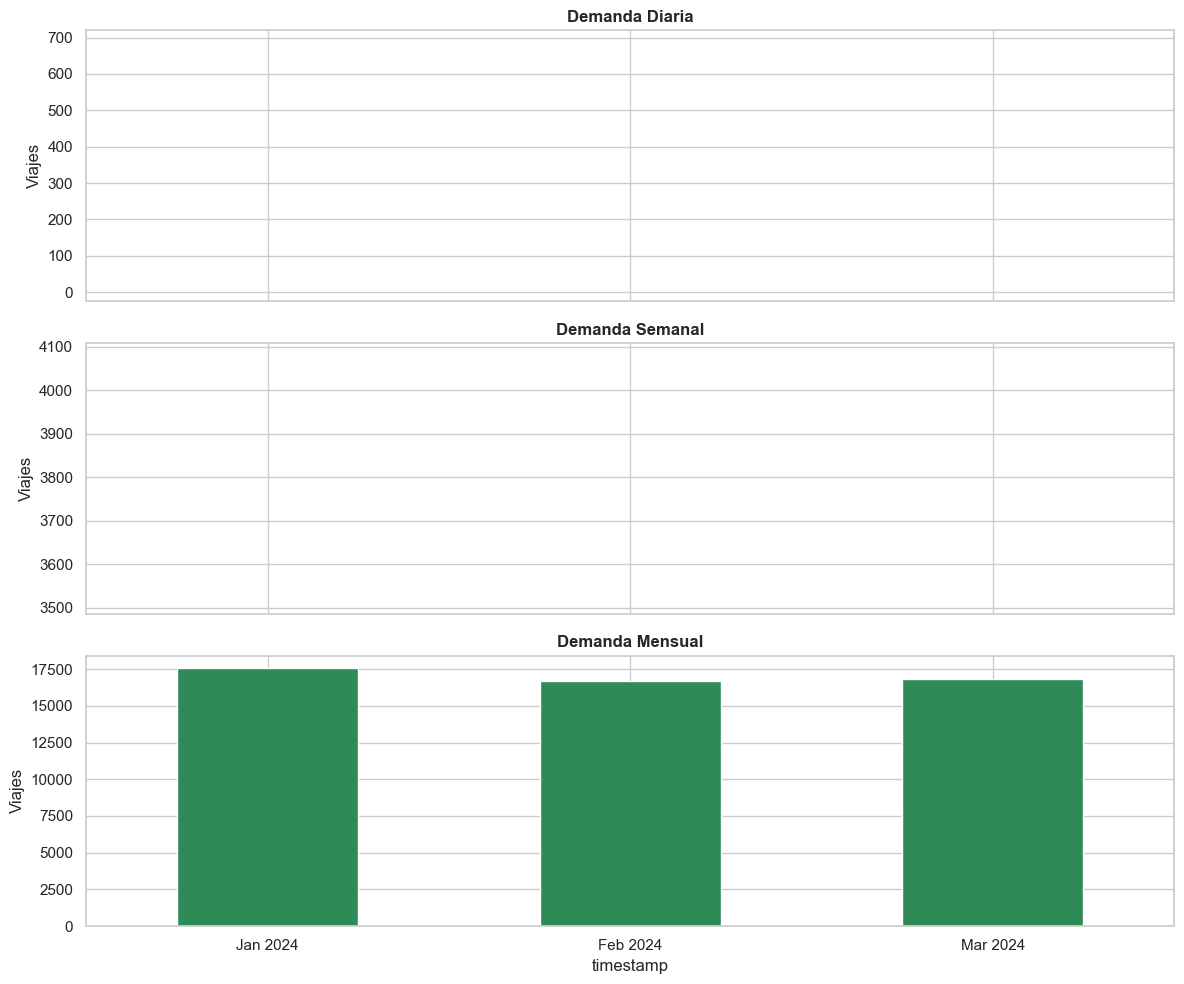

In [5]:
# Visualizacion: comparar granularidades
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

df.resample('D').sum().plot(ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Demanda Diaria', fontweight='bold')
axes[0].set_ylabel('Viajes')

df.resample('W').sum().plot(ax=axes[1], color='darkorange', legend=False, marker='o')
axes[1].set_title('Demanda Semanal', fontweight='bold')
axes[1].set_ylabel('Viajes')

df.resample('ME').sum().plot(ax=axes[2], kind='bar', color='seagreen', legend=False)
axes[2].set_title('Demanda Mensual', fontweight='bold')
axes[2].set_ylabel('Viajes')
axes[2].set_xticklabels([d.strftime('%b %Y') for d in monthly_sum.index], rotation=0)

plt.tight_layout()
plt.show()

---

## 2. `resample()` — Upsampling

Aumentar la granularidad temporal e interpolar los valores faltantes.

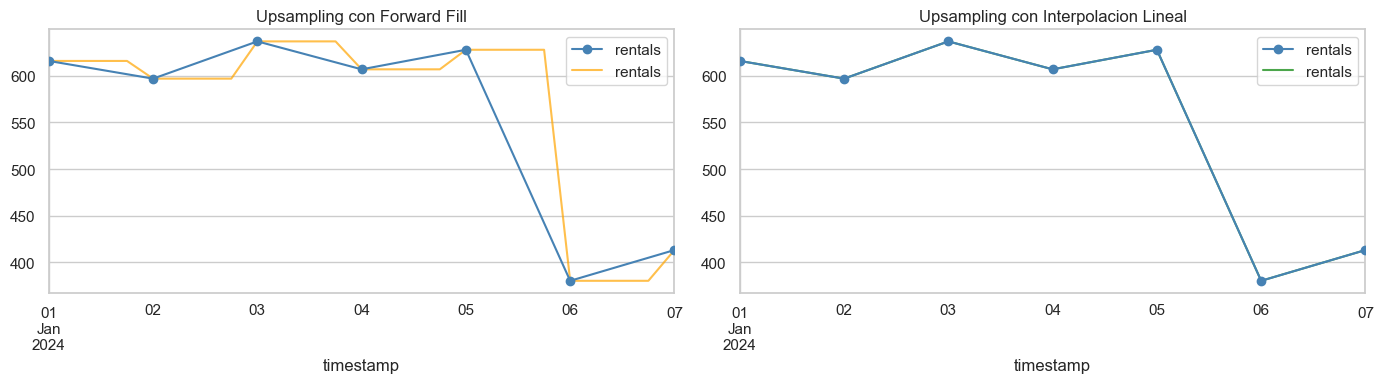

In [6]:
# Datos diarios → cada 6 horas con interpolacion
sparse = daily_sum.head(7)  # solo una semana

up_ffill  = sparse.resample('6h').ffill()          # rellenar hacia adelante
up_linear = sparse.resample('6h').interpolate('linear')  # interpolacion lineal

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sparse.plot(ax=axes[0], marker='o', color='steelblue', label='Original (diario)', zorder=3)
up_ffill.plot(ax=axes[0], color='orange', alpha=0.7, label='Forward fill (6h)')
axes[0].set_title('Upsampling con Forward Fill')
axes[0].legend()

sparse.plot(ax=axes[1], marker='o', color='steelblue', label='Original (diario)', zorder=3)
up_linear.plot(ax=axes[1], color='green', alpha=0.7, label='Interpolacion lineal (6h)')
axes[1].set_title('Upsampling con Interpolacion Lineal')
axes[1].legend()

plt.tight_layout()
plt.show()

---

## 3. `rolling()` — Ventanas deslizantes

Calcula estadísticas sobre una **ventana de N periodos** que se desplaza a lo largo de la serie.

In [7]:
# Trabajamos con la serie diaria (mas legible)
daily = df.resample('D').sum()

daily['ma_7']  = daily['rentals'].rolling(window=7).mean()   # media movil 7 dias
daily['ma_14'] = daily['rentals'].rolling(window=14).mean()  # media movil 14 dias

print("Primeras filas (NaN hasta que la ventana esta completa):")
daily.head(16)

Primeras filas (NaN hasta que la ventana esta completa):


,rentals,ma_7,ma_14
timestamp,,,
2024-01-01,616,NaN,NaN
2024-01-02,597,NaN,NaN
2024-01-03,637,NaN,NaN
2024-01-04,607,NaN,NaN
2024-01-05,628,NaN,NaN
2024-01-06,380,NaN,NaN
2024-01-07,413,554.000000,NaN
2024-01-08,629,555.857143,NaN
2024-01-09,661,565.000000,NaN


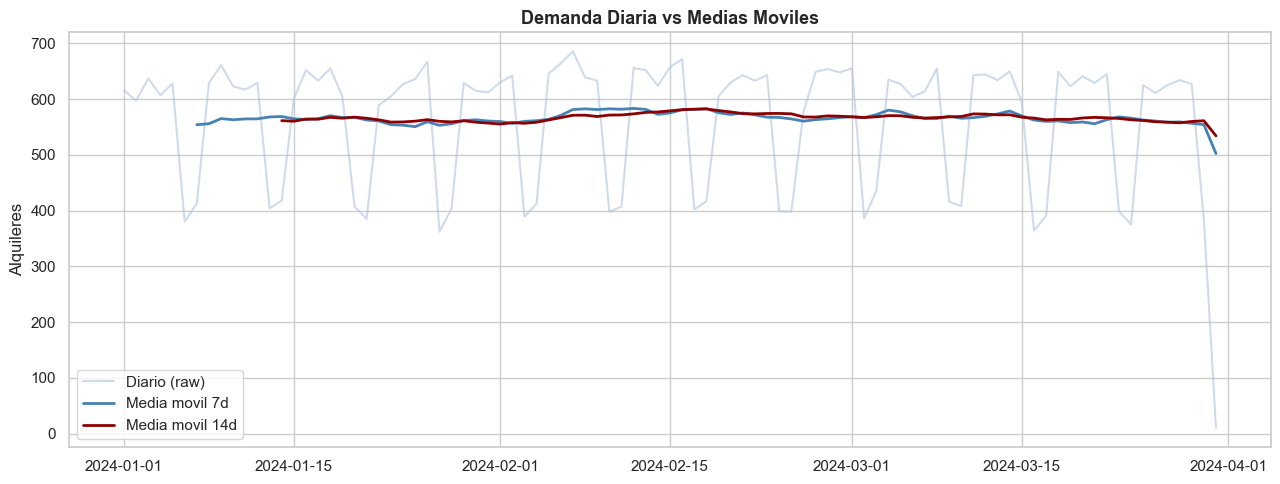

In [8]:
# Visualizacion: ruido vs tendencia suavizada
fig, ax = plt.subplots(figsize=(13, 5))

ax.plot(daily.index, daily['rentals'], color='lightsteelblue', alpha=0.6, label='Diario (raw)')
ax.plot(daily.index, daily['ma_7'],  color='steelblue',  lw=2, label='Media movil 7d')
ax.plot(daily.index, daily['ma_14'], color='darkred',    lw=2, label='Media movil 14d')

ax.set_title('Demanda Diaria vs Medias Moviles', fontsize=13, fontweight='bold')
ax.set_ylabel('Alquileres')
ax.legend()
plt.tight_layout()
plt.show()

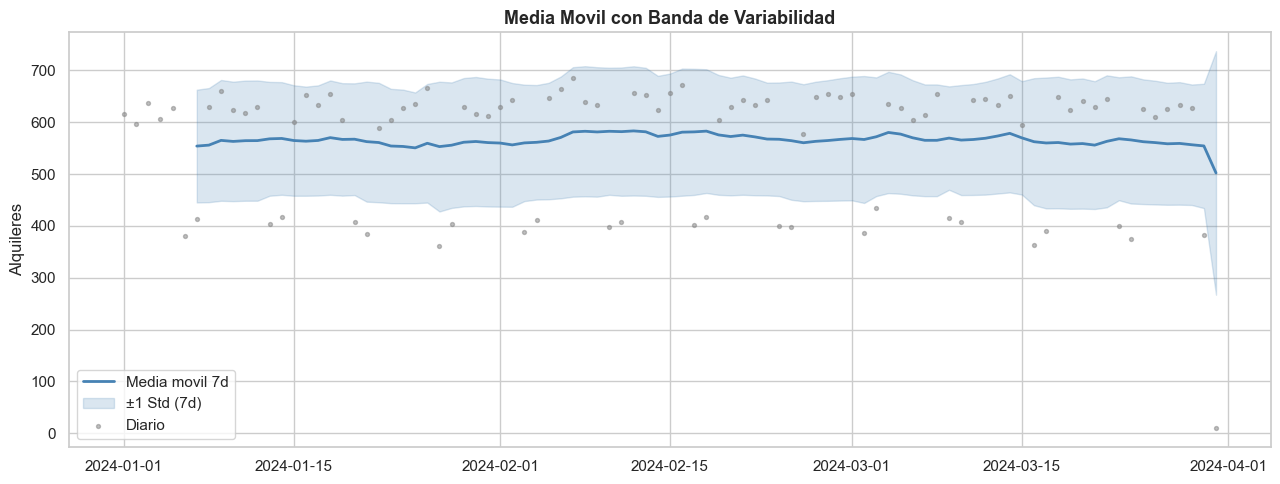

In [9]:
# rolling con otras estadisticas
daily['std_7']  = daily['rentals'].rolling(7).std()          # desviacion tipica
daily['max_7']  = daily['rentals'].rolling(7).max()          # maximo deslizante

# Banda de confianza: media ± 1 std
fig, ax = plt.subplots(figsize=(13, 5))

ax.plot(daily.index, daily['ma_7'], color='steelblue', lw=2, label='Media movil 7d')
ax.fill_between(
    daily.index,
    daily['ma_7'] - daily['std_7'],
    daily['ma_7'] + daily['std_7'],
    alpha=0.2, color='steelblue', label='±1 Std (7d)'
)
ax.scatter(daily.index, daily['rentals'], s=8, color='gray', alpha=0.5, label='Diario')

ax.set_title('Media Movil con Banda de Variabilidad', fontsize=13, fontweight='bold')
ax.set_ylabel('Alquileres')
ax.legend()
plt.tight_layout()
plt.show()

---

## 4. `ewm()` — Media Móvil Exponencial

A diferencia de `rolling()`, el **EWM** da más peso a los valores recientes.  
El parámetro `span` controla cuánto pesan los datos antiguos.

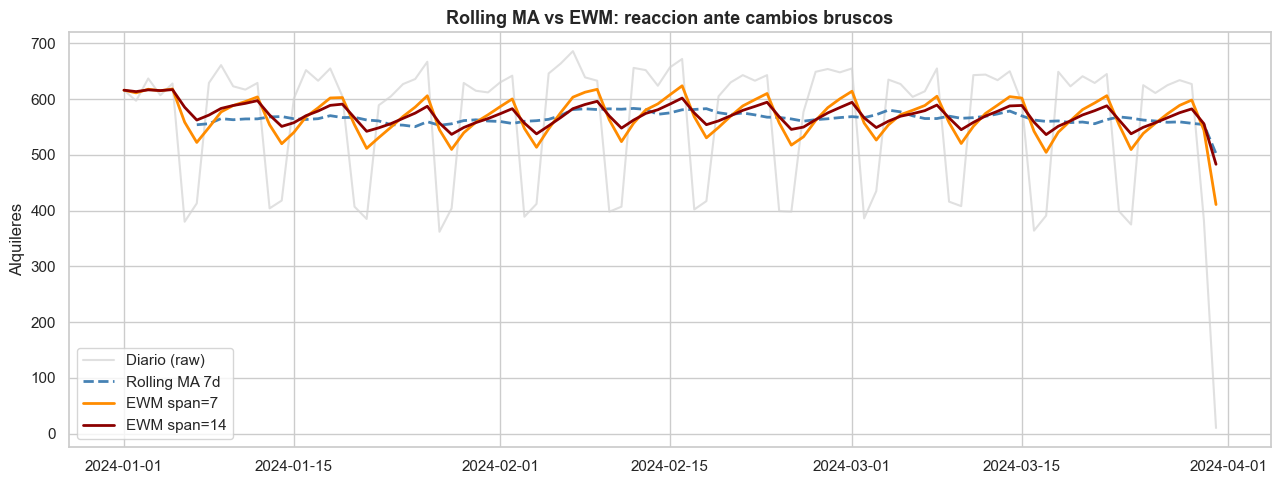

In [10]:
daily['ewm_7']  = daily['rentals'].ewm(span=7,  adjust=False).mean()
daily['ewm_14'] = daily['rentals'].ewm(span=14, adjust=False).mean()

fig, ax = plt.subplots(figsize=(13, 5))

ax.plot(daily.index, daily['rentals'], color='lightgray', alpha=0.7, label='Diario (raw)')
ax.plot(daily.index, daily['ma_7'],   color='steelblue', lw=2, linestyle='--', label='Rolling MA 7d')
ax.plot(daily.index, daily['ewm_7'],  color='darkorange', lw=2, label='EWM span=7')
ax.plot(daily.index, daily['ewm_14'], color='darkred',    lw=2, label='EWM span=14')

ax.set_title('Rolling MA vs EWM: reaccion ante cambios bruscos', fontsize=13, fontweight='bold')
ax.set_ylabel('Alquileres')
ax.legend()
plt.tight_layout()
plt.show()

### ¿Cuándo usar cada uno?

| Técnica | Reacción a cambios | Hueco inicial | Mejor para |
|---------|-------------------|---------------|------------|
| `rolling()` | Lenta (igual peso a todo) | Sí (N-1 NaN) | Tendencia estable |
| `ewm()` | Rápida (más peso a lo reciente) | No | Señales cambiantes |

---

## 5. Aplicación práctica: detección de semanas atípicas

In [11]:
# Calcular z-score sobre la media movil
window = 14
daily['roll_mean'] = daily['rentals'].rolling(window).mean()
daily['roll_std']  = daily['rentals'].rolling(window).std()
daily['z_score']   = (daily['rentals'] - daily['roll_mean']) / daily['roll_std']

# Dias por encima de 2 desviaciones tipicas
outliers = daily[daily['z_score'].abs() > 2]
print(f"Dias atipicos detectados: {len(outliers)}")
print(outliers[['rentals', 'roll_mean', 'z_score']].round(2))

Dias atipicos detectados: 1
            rentals  roll_mean  z_score
timestamp                              
2024-03-31       10      534.0    -2.86


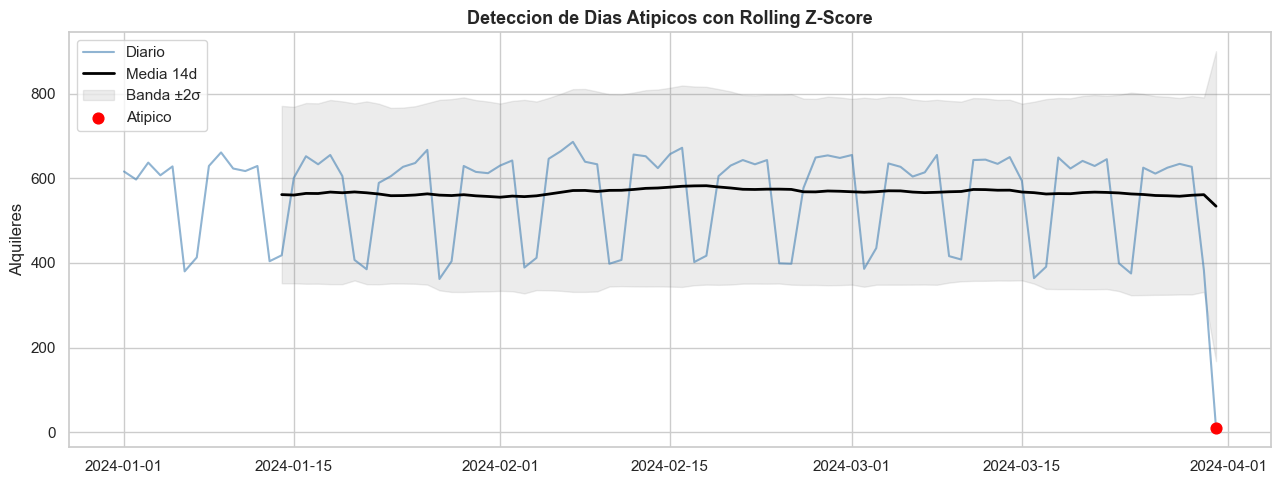

In [12]:
fig, ax = plt.subplots(figsize=(13, 5))

ax.plot(daily.index, daily['rentals'], color='steelblue', alpha=0.6, label='Diario')
ax.plot(daily.index, daily['roll_mean'], color='black', lw=2, label=f'Media {window}d')
ax.fill_between(
    daily.index,
    daily['roll_mean'] - 2 * daily['roll_std'],
    daily['roll_mean'] + 2 * daily['roll_std'],
    alpha=0.15, color='gray', label='Banda ±2σ'
)
ax.scatter(outliers.index, outliers['rentals'], color='red', zorder=5, s=60, label='Atipico')

ax.set_title('Deteccion de Dias Atipicos con Rolling Z-Score', fontsize=13, fontweight='bold')
ax.set_ylabel('Alquileres')
ax.legend()
plt.tight_layout()
plt.show()

---

## Resumen

| Herramienta | Código | Resultado |
|-------------|--------|-----------|
| Downsampling | `df.resample('D').sum()` | Serie de menor frecuencia |
| Upsampling | `df.resample('6h').interpolate()` | Serie de mayor frecuencia |
| Ventana fija | `df.rolling(7).mean()` | Suavizado uniforme |
| Ventana exponencial | `df.ewm(span=7).mean()` | Suavizado reactivo |
| Z-score rolling | `(x - roll_mean) / roll_std` | Detección de anomalías |

---

## Ejercicio

Calcula la **demanda acumulada por semana** (`resample('W').sum()`) y añade  
una columna con el **cambio porcentual** respecto a la semana anterior usando `.pct_change()`.

In [13]:
weekly = df.resample('W').sum()
weekly['pct_change'] = weekly['rentals'].pct_change() * 100

print("Demanda semanal y variacion:")
print(weekly.round(1).to_string())

Demanda semanal y variacion:
            rentals  pct_change
timestamp                      
2024-01-07     3878         NaN
2024-01-14     3981         2.7
2024-01-21     3938        -1.1
2024-01-28     3890        -1.2
2024-02-04     3929         1.0
2024-02-11     4073         3.7
2024-02-18     4080         0.2
2024-02-25     3951        -3.2
2024-03-03     4004         1.3
2024-03-10     3959        -1.1
2024-03-17     3920        -1.0
2024-03-24     3961         1.0
2024-03-31     3515       -11.3


---

**Anterior:** [10.01 - Fundamentos de Datetime](./10_01_datetime_basics.ipynb)  
**Siguiente:** [10.03 - Tendencias y Patrones Temporales](./10_03_trends_and_patterns.ipynb)